In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tabulate
from scipy import stats
from autorank import autorank,create_report,plot_stats
pd.set_option("chained_assignment", None)
pd.set_option("display.max_rows", 5000)
pd.set_option("display.max_columns", 5000)
pd.set_option("display.width", 10000)

def load_priorband_data():
    df = pd.read_parquet("data_for_anton.parquet")
    df=df.reset_index()
    df_collection=[]
    for seed_nr in range(50):
        partial_df=df[["benchmark","prior","algorithm","used_fidelity"]]
        partial_df["value"]=df[f"seed-{seed_nr}"]
        partial_df["seed"]=seed_nr
        df_collection.append(partial_df)
        print(f"Seed {seed_nr+1}/50", end="\r", flush=True)
    df_complete=pd.concat(df_collection,ignore_index=True)
    df_complete[["value","used_fidelity"]]=df_complete[["value","used_fidelity"]].astype(float)
    return df_complete

df=load_priorband_data()

In [2]:

algo_dict={"rs_hb_pb":["random_search","hyperband","pb_mutation_dynamic_geometric-default-at-target"]}
#algo_dict["fig7"]=["random_search_prior","bo","bohb","priorband_bo"]
prior_dict={"good+bad":["at25","bad"]}
benchmarks=["jahs_cifar10","jahs_colorectal_histology","jahs_fashion_mnist","lcbench-126026","lcbench-167190","lcbench-168330","lcbench-168910","lcbench-189906","cifar100_wideresnet_2048","imagenet_resnet_512","lm1b_transformer_2048","translatewmt_xformer_64"]
label_dict={'random_search': 'RS', 'hyperband': 'HB', 'pb_mutation_dynamic_geometric-default-at-target': 'PB', 'jahs_cifar10': 'JAHS-C10', 'jahs_colorectal_histology': 'JAHS-CH', 'jahs_fashion_mnist': 'JAHS-FM', 'lcbench-126026': 'LC-126026', 'lcbench-167190': 'LC-167190', 'lcbench-168330': 'LC-168330', 'lcbench-168910': 'LC-168910', 'lcbench-189906': 'LC-189906', 'cifar100_wideresnet_2048': 'PD1-Cifar100', 'imagenet_resnet_512': 'PD1-ImageNet', 'lm1b_transformer_2048': 'PD1-LM1B', 'translatewmt_xformer_64': 'PD1-WMT',"random_search_prior":"RS+Prior","bo":"BO","pibo":"PiBO","bohb":"BOHB","priorband_bo":"PriorBand+BO"}


for priortype in df["prior"].unique():
    prior_dict[priortype]=[priortype]


df_dict={}
for prior_key,prior_value in prior_dict.items():
    df_dict[prior_key]={}
    for b_n,benchmark in enumerate(benchmarks):
        print(f"Prior {prior_key}, Benchmark {b_n+1}/{len(benchmarks)}      ", end="\r", flush=True)
        df_dict[prior_key][benchmark]={}
        for algo_key,algo_value in algo_dict.items():
            df_dict[prior_key][benchmark][algo_key]=df.loc[(df["prior"].isin(prior_value))&(df["algorithm"].isin(algo_value))&(df["benchmark"]==benchmark)].reset_index(drop=True)

In [3]:
def create_lmem_incumbent(priors:list[str],fs,algorithms:list[str],algo_group:str,benchmarks:list[str],df_dict:pd.DataFrame):
    output={}
    output["dataset"]={}
    output["mean_std"]={}
    for p_n,prior in enumerate(priors):
        output["dataset"][prior]=pd.DataFrame()
        output["mean_std"][prior]={}
        for n_f,max_f in enumerate(fs):
            labels=[]
            for algo in algorithms:
                labels.append(label_dict[algo])
            output["mean_std"][prior][max_f]=pd.DataFrame(columns=["benchmark"]+labels)
            for b_n,benchmark in enumerate(benchmarks):
                df_at_point=df_dict[prior][benchmark][algo_group]
                df_at_point=df_at_point.loc[df_at_point["used_fidelity"]<=max_f]
                for seed in df_at_point["seed"].unique():
                    print(f"Prior {prior} ({p_n+1}), Fidelity {n_f+1}/{len(fs)}, Benchmark {b_n+1}/{len(benchmarks)}          ", end="\r", flush=True)
                    for algo in algorithms:
                        df_criteria=df_at_point.loc[(df_at_point["seed"]==seed)&(df_at_point["algorithm"]==algo)].iloc[-1].to_frame().T
                        df_criteria["used_fidelity"]=max_f
                        output["dataset"][prior]=pd.concat([output["dataset"][prior],df_criteria],ignore_index=True)
            output["dataset"][prior][["value","used_fidelity"]]=output["dataset"][prior][["value","used_fidelity"]].astype(float)
            output["dataset"][prior]["seed"]=output["dataset"][prior]["seed"].astype(int)
            
    return output["dataset"]


In [4]:
from significance_analysis import conduct_analysis

fig5={}
fig5["algo_group"]="rs_hb_pb"
fig5["algorithms"]=algo_dict[fig5["algo_group"]].copy()
fig5["priors"]=["good+bad","at25","bad"]
fig5["benchmarks"]=benchmarks
fig5["max_f"]=np.linspace(1,12,20).tolist()

fig5["dataset"]=create_lmem_incumbent(fig5["priors"],fig5["max_f"],fig5["algorithms"],fig5["algo_group"],fig5["benchmarks"],df_dict)

Prior good+bad (1)


boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 

P-value: 0.0

As the p-value 0.0 is smaller than 0.05, we can reject the Null-Hypothesis that the model that does not consider the algorithm and the used_fidelity describes the data as well as the one that does. Therefore there is significant difference within algorithm and the used_fidelity.

P-values adjusted by tukey method for family of 3 estimates
The best performing algorithm in used_fidelity-class 1.0 is random_search, all others perform significantly worse.

The best performing algorithm in used_fidelity-class 1.5789473684210527 is random_search, all others perform significantly worse.

The best performing algorithm in used_fidelity-class 2.1578947368421053 is random_search, all others perform significantly worse.

The best performing algorithm in used_fidelity-class 2.736842105263158 is random_search, but ['hyperband'] are only insignificantly worse.

The best performing algorit

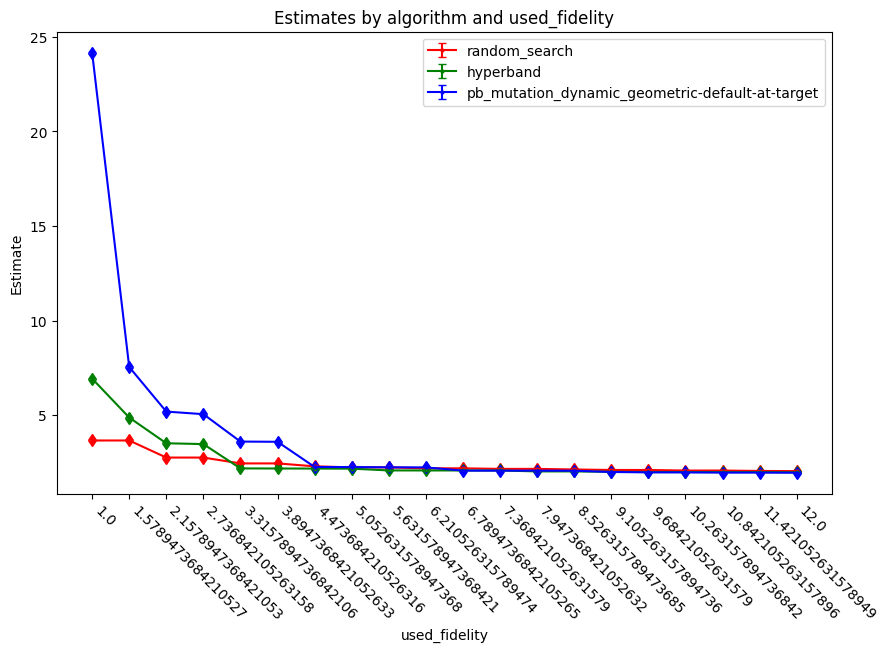

Prior at25 (2)
boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 

P-value: 0.0

As the p-value 0.0 is smaller than 0.05, we can reject the Null-Hypothesis that the model that does not consider the algorithm and the used_fidelity describes the data as well as the one that does. Therefore there is significant difference within algorithm and the used_fidelity.

P-values adjusted by tukey method for family of 3 estimates
The best performing algorithm in used_fidelity-class 1.0 is pb_mutation_dynamic_geometric-default-at-target, all others perform significantly worse.

The best performing algorithm in used_fidelity-class 1.5789473684210527 is pb_mutation_dynamic_geometric-default-at-target, all others perform significantly worse.

The best performing algorithm in used_fidelity-class 2.1578947368421053 is pb_mutation_dynamic_geometric-default-at-target, all others perform significantly worse.

The best performing algorithm in used_fidelity-cla

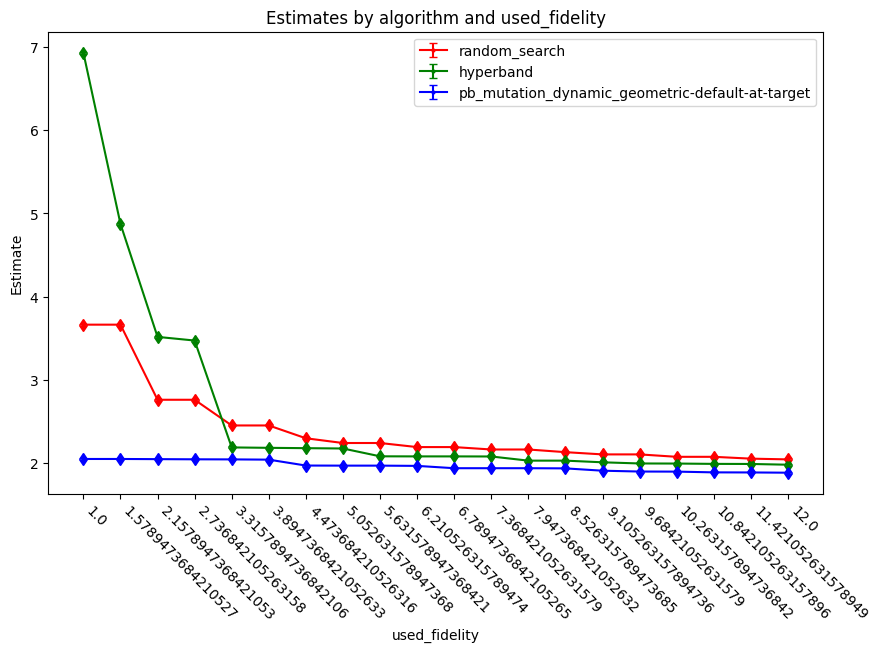

Prior bad (3)
boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 

P-value: 0.0

As the p-value 0.0 is smaller than 0.05, we can reject the Null-Hypothesis that the model that does not consider the algorithm and the used_fidelity describes the data as well as the one that does. Therefore there is significant difference within algorithm and the used_fidelity.

P-values adjusted by tukey method for family of 3 estimates
The best performing algorithm in used_fidelity-class 1.0 is random_search, all others perform significantly worse.

The best performing algorithm in used_fidelity-class 1.5789473684210527 is random_search, all others perform significantly worse.

The best performing algorithm in used_fidelity-class 2.1578947368421053 is random_search, all others perform significantly worse.

The best performing algorithm in used_fidelity-class 2.736842105263158 is random_search, but ['hyperband'] are only insignificantly worse.

The best perf

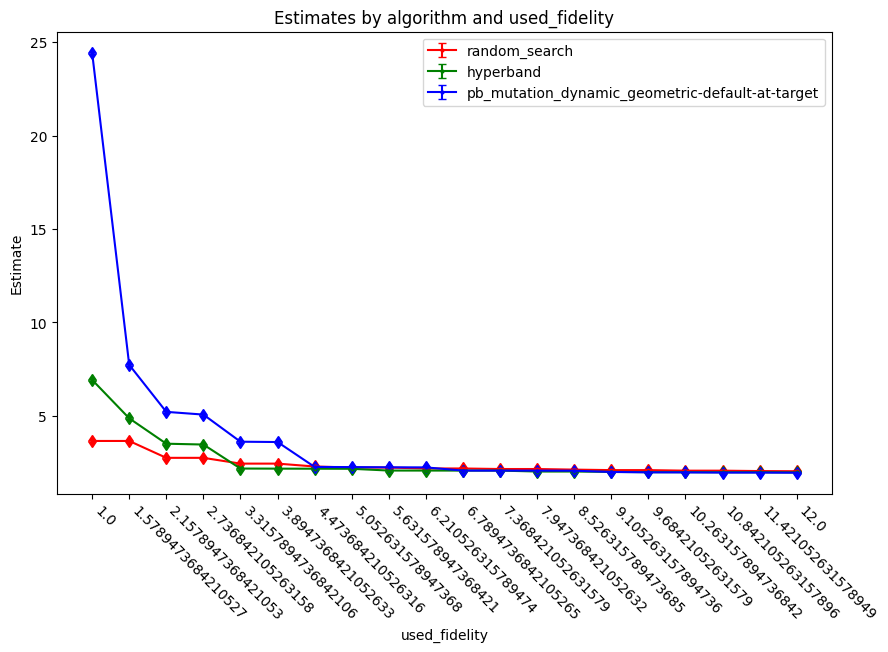

Done


In [5]:
result_dict={}
for p_n,priortype in enumerate(fig5["priors"]):
    print(f"Prior {priortype} ({p_n+1})")
    #fig5["dataset"][priortype]=fig5["dataset"][priortype].replace({"algorithm": label_dict,"benchmark": label_dict})
    result_dict[priortype]=conduct_analysis(fig5["dataset"][priortype],"value","algorithm","benchmark","used_fidelity",fidelity="used_fidelity",continuous_fidelity=False,show_plots=True,verbosity=1)[1]
print("Done")


In [6]:
print(result_dict["bad"])

(                                          algorithm  used_fidelity_bins  Estimate  2.5_ci  97.5_ci     SE      DF
1                                     random_search                 1.0     3.662   0.654    6.671  1.388  12.614
2                                         hyperband                 1.0     6.932   3.924    9.940  1.388  12.614
3   pb_mutation_dynamic_geometric-default-at-target                 1.0    24.433  21.425   27.441  1.388  12.614
4                                     random_search  1.5789473684210527     3.662   0.654    6.671  1.388  12.614
5                                         hyperband  1.5789473684210527     4.874   1.866    7.882  1.388  12.614
6   pb_mutation_dynamic_geometric-default-at-target  1.5789473684210527     7.734   4.726   10.743  1.388  12.614
7                                     random_search  2.1578947368421053     2.759  -0.249    5.767  1.388  12.614
8                                         hyperband  2.1578947368421053     3.515   0.5